# Sea surface temperature and salinity analysis using BRAN 2020 data model 
#### Analyis conducted using BRAN2020 model. Full data catalogue available at: 
- https://dapds00.nci.org.au/thredds/catalog/gb6/BRAN/BRAN2020/catalog.html 

#### References used for this notebook: 
- https://tristansalles.github.io/EnviReef/5-xarray/examples/maps.html

<div class="alert alert-block alert-info">
<b>Step One:</b> Open BRAN2020 netCDF files and crop to make data managable.
</div>

Install python libraries

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

import netCDF4
from netCDF4 import Dataset, num2date
import datetime as dt

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import cmocean

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

/usr/lib/gdalplugins/ogr_Parquet.so: undefined symbol: _ZNK5arrow8DataType18ComputeFingerprintB5cxx11Ev
/usr/lib/gdalplugins/ogr_Parquet.so: undefined symbol: _ZNK5arrow8DataType18ComputeFingerprintB5cxx11Ev
libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
/usr/lib/gdalplugins/ogr_Arrow.so: undefined symbol: _ZNK5arrow8DataType18ComputeFingerprintB5cxx11Ev
/usr/lib/gdalplugins/ogr_Arrow.so: undefined symbol: _ZNK5arrow8DataType18ComputeFingerprintB5cxx11Ev
/usr/lib/gdalplugins/ogr_Parquet.so: undefined symbol: _ZNK5arrow8DataType18ComputeFingerprintB5cxx11Ev
/usr/lib/gdalplugins/ogr_Parquet.so: undefined symbol: _ZNK5arrow8DataType18ComputeFingerprintB5cxx11Ev
libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
/usr/lib/gdalplugins/ogr_Arrow.so: undefined symbol: _ZNK5arrow8Data

Specify time period and variable (temperature or salinity) and load BRAN2020 dataset

In [2]:
month_st = 1   # Starting month (Jan)
month_ed = 5   # Ending month (May)
year = 2022   # Year
variable = 'temp' #Temperature = temp, salinity = salt

base_url = "https://dapds00.nci.org.au/thredds/dodsC/gb6/BRAN/BRAN2020/daily/ocean_" 

# Based on file naming convention on BRAN2020 server
ocean_var = [f"{base_url}{variable}_{year}_{month:02}.nc" for month in range(month_st, month_ed+1)]

ocean_var

['https://dapds00.nci.org.au/thredds/dodsC/gb6/BRAN/BRAN2020/daily/ocean_temp_2022_01.nc',
 'https://dapds00.nci.org.au/thredds/dodsC/gb6/BRAN/BRAN2020/daily/ocean_temp_2022_02.nc',
 'https://dapds00.nci.org.au/thredds/dodsC/gb6/BRAN/BRAN2020/daily/ocean_temp_2022_03.nc',
 'https://dapds00.nci.org.au/thredds/dodsC/gb6/BRAN/BRAN2020/daily/ocean_temp_2022_04.nc',
 'https://dapds00.nci.org.au/thredds/dodsC/gb6/BRAN/BRAN2020/daily/ocean_temp_2022_05.nc']

Specify geographic range of data

In [3]:
min_lon = 148.
min_lat = -48.
max_lat = -25.
max_lon = 160.

Create netCDF files for each month: 1) crop dataset to desired geographic range, 2) drop unnessecary variables from dataset and 3) crop data to depth within photic zone

In [4]:
k = 0
for k in range(0,len(ocean_var)):
    ds_ovar = xr.open_dataset(ocean_var[k], chunks='auto', 
                                 drop_variables=['Time_bounds', 'average_DT', 'average_T1' , 
                                                 'average_T2', 'st_edges_ocean', 'nv'])
    mask_lon = (ds_ovar.xt_ocean >= min_lon) & (ds_ovar.xt_ocean <= max_lon)
    mask_lat = (ds_ovar.yt_ocean >= min_lat) & (ds_ovar.yt_ocean <= max_lat)
    cropped_ds = ds_ovar.where(mask_lon & mask_lat, drop=True)
    photicZone = cropped_ds.isel(st_ocean=slice(0,4)).mean(dim='st_ocean')
    photicZone.to_netcdf('photicZone'+str(k)+'.nc')

Open datasets from each month and create an aggregate netCDF file of all months

In [5]:
photicZone = xr.open_mfdataset('photicZone*.nc')
photicZone.to_netcdf(str(variable)+'_photic_Zone_JantoMay_'+str(year)+'.nc')

<div class="alert alert-block alert-info">
<b>Step Two:</b> Create a map of SST or salinity within geographic range.
</div>

Open aggregate dataset and calculate mean ocean temperature across the timeframe 

In [6]:
photicZone = xr.open_mfdataset(str(variable)+'_photic_Zone_JantoMay_'+str(year)+'.nc')
varMean = photicZone[variable].mean(dim="Time")

Specify varible name, units, colourbar and scale for plot

For temperature:

In [7]:
varname = 'Temperature'
units = '°C'
scalemin = 11
scalemax = 24
color = cmocean.cm.balance

For salinity:

In [ ]:
varname = 'Salinity'
units = 'psu'
scalemin = 35
scalemax = 35.8
color = cmocean.cm.haline

Run the plot mapping average SST or salinity in photic zone across the months of January to May and save as .png file

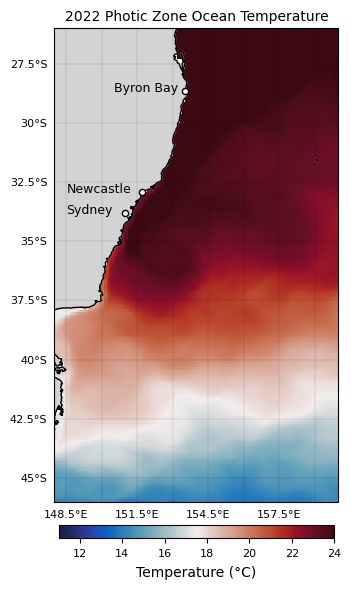

<Figure size 640x480 with 0 Axes>

In [8]:
# Figure size
size = (6, 6)

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([148, 160, -26, -46], ccrs.PlateCarree())

# Plotting using Matplotlib 
cf = varMean.plot( 
  transform=ccrs.PlateCarree(), cmap=color,
    vmin = scalemin, vmax = scalemax,
    add_colorbar=False
)

# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                    orientation="horizontal")
cbar.set_label(varname+' ('+units+')', rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
plt.title(str(year) + ' ' + "Photic Zone Ocean "+varname, fontsize=10)

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=1)

# Sydney dot
syd_lat = -33.8
syd_lon = 151
ax.scatter(syd_lon, syd_lat, c='white', zorder=2, s=20, edgecolors='k', linewidth=1,
           transform=ccrs.PlateCarree())
ax.plot(syd_lon, syd_lat, transform=ccrs.Geodetic())
ax.text(syd_lon-2.5, syd_lat, 'Sydney', transform=ccrs.Geodetic(), fontsize = 9)


#Newcastle plot
newc_lat = -32.92
newc_lon = 151.70
ax.scatter(newc_lon, newc_lat, c='white', zorder=2, s=20, edgecolors='k', linewidth=1,
            transform=ccrs.PlateCarree())
ax.plot(newc_lon, newc_lat, transform=ccrs.Geodetic())
ax.text(newc_lon-3.2, newc_lat, 'Newcastle', transform=ccrs.Geodetic(), fontsize = 9)

#Byron Bay Plot
bbay_lat = -28.64
bbay_lon = 153.50
ax.scatter(bbay_lon, bbay_lat, c='white', zorder=2, s=20, edgecolors='k', linewidth=1,
            transform=ccrs.PlateCarree())
ax.plot(bbay_lon, bbay_lat, transform=ccrs.Geodetic())
ax.text(bbay_lon-3, bbay_lat, 'Byron Bay', transform=ccrs.Geodetic(), fontsize = 9)

plt.tight_layout()
plt.savefig(str(variable)+'_'+str(year)+'.png') #,dpi=300)
plt.show()
fig.clear()
plt.close(fig)
plt.clf()


<div class="alert alert-block alert-info">
<b>Step Three (For temperature only, for salinity skip to step four):</b> Analyse the geographic region of thermal tolerance.
</div>

Specify the temperature range to identify maximum and minimum latitudes that provide environmental conditions vagrant fish larvae could survive in

In [10]:
minRange = 18
maxRange = 20

ids = np.where(np.logical_and(varMean>=minRange,varMean<=maxRange))
latVal = varMean.yt_ocean.values[ids[0]]
lonVal = varMean.xt_ocean.values[ids[1]]

print('Range lon:',lonVal.min(),lonVal.max())
print('Range lat:',latVal.min(),latVal.max())

Range lon: 148.0500030517578 159.9499969482422
Range lat: -42.849998474121094 -37.150001525878906


Run plot with addition of visual representation of region in which average temperature is between 18 and 20 degrees celcius and save as .png file

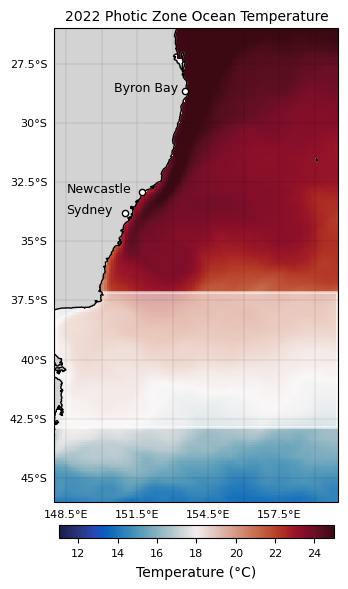

<Figure size 640x480 with 0 Axes>

In [11]:
# Figure size
size = (6, 6)

# Color from cmocean
color = cmocean.cm.balance

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([148, 160, -26, -46], ccrs.PlateCarree())

# Plotting using Matplotlib 
cf = varMean.plot( 
  transform=ccrs.PlateCarree(), cmap=color,
    vmin = 11, vmax = 25,
    add_colorbar=False
)

# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                    orientation="horizontal")
cbar.set_label("Temperature (°C)", rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
plt.title(str(year) + ' ' + "Photic Zone Ocean Temperature", fontsize=10)

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=1)

# Sydney dot
syd_lat = -33.8
syd_lon = 151
ax.scatter(syd_lon, syd_lat, c='white', zorder=2, s=20, edgecolors='k', linewidth=1,
           transform=ccrs.PlateCarree())
ax.plot(syd_lon, syd_lat, transform=ccrs.Geodetic())
ax.text(syd_lon-2.5, syd_lat, 'Sydney', transform=ccrs.Geodetic(), fontsize = 9)


#Newcastle plot
newc_lat = -32.92
newc_lon = 151.70
ax.scatter(newc_lon, newc_lat, c='white', zorder=2, s=20, edgecolors='k', linewidth=1,
            transform=ccrs.PlateCarree())
ax.plot(newc_lon, newc_lat, transform=ccrs.Geodetic())
ax.text(newc_lon-3.2, newc_lat, 'Newcastle', transform=ccrs.Geodetic(), fontsize = 9)

#Byron Bay Plot
bbay_lat = -28.64
bbay_lon = 153.50
ax.scatter(bbay_lon, bbay_lat, c='white', zorder=2, s=20, edgecolors='k', linewidth=1,
            transform=ccrs.PlateCarree())
ax.plot(bbay_lon, bbay_lat, transform=ccrs.Geodetic())
ax.text(bbay_lon-3, bbay_lat, 'Byron Bay', transform=ccrs.Geodetic(), fontsize = 9)

#Create bounds of temp range 18-20
ax.add_patch(Rectangle((lonVal.min(), latVal.min()), lonVal.max()-lonVal.min(), 
                       latVal.max()-latVal.min(),
            edgecolor='w',
            facecolor='w',
            alpha=0.6,
            lw=2)
            )


plt.tight_layout()
plt.savefig('temp'+'_'+str(year)+'_range.png') #,dpi=300)
plt.show()
fig.clear()
plt.close(fig)
plt.clf()



<div class="alert alert-block alert-info">
<b>Step four:</b> Create GIF of changing temperature or salinity across multiple years.
</div>


Install python libraries and specify years to create timeseries

In [12]:
import os
import shutil
from PIL import Image 

startyear = 2013
endyear = 2022

imgs = []
for k in range(startyear,(endyear+1)):
    imgs.append(str(variable)+'_'+str(k)+'.png')


Aggregate images and create GIF

In [ ]:
# Create the frames
frames = []
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save(str(variable)+str(startyear)+'to'+str(endyear)+'.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=800, loop=0)

End.